In [1]:
import csv
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import cmasher as cmr

DATA_PATH = "../data"
SOURCE_FILE = f"{DATA_PATH}/inflation/inflation.csv"
HOST = "local.data-workshop.workshops.utkusarioglu.com"
PORT = 5432
DB_NAME = "postgres"
USER = "postgres"
PASSWORD = "postgres"

In [2]:
df = pd.read_csv(SOURCE_FILE)

In [2]:
def db_connection():
    engine =  create_engine(
        f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"
    )
    return engine.connect()

In [4]:
with open("./sql/country-names.sql") as sql:
    with db_connection() as conn:
        countries = pd.read_sql_query(sql.read(), conn)
countries


,country_name,country_code,indicator_name
0,Aruba,ABW,"Inflation, consumer prices (annual %)"
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)"
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)"
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)"
4,Angola,AGO,"Inflation, consumer prices (annual %)"
...,...,...,...
261,Kosovo,XKX,"Inflation, consumer prices (annual %)"
262,"Yemen, Rep.",YEM,"Inflation, consumer prices (annual %)"
263,South Africa,ZAF,"Inflation, consumer prices (annual %)"
264,Zambia,ZMB,"Inflation, consumer prices (annual %)"


In [5]:
with open("./sql/select-countries.sql") as sql:
    with db_connection() as conn:
        inflation_raw = pd.read_sql_query(sql.read(), conn)
inflation_raw


,country_name,country_code,indicator_name,indicator_code,year_1960,year_1961,year_1962,year_1963,year_1964,year_1965,...,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021
0,Switzerland,CHE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.438795,1.845398,4.315993,3.440213,3.080557,3.414478,...,-0.692552,-0.217323,-0.013203,-1.143909,-0.434619,0.533788,0.936335,0.362886,-0.725875,0.581814
1,Germany,DEU,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,...,2.008491,1.504721,0.906798,0.514421,0.491749,1.509497,1.732168,1.445667,0.506690,3.142970
2,Japan,JPN,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,3.574511,5.368462,6.835440,6.706905,3.800390,6.655991,...,-0.044065,0.335038,2.759227,0.795280,-0.127259,0.484200,0.989095,0.468776,-0.024996,-0.233353
3,Turkiye,TUR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,5.664740,3.172857,3.888320,6.362707,1.119638,4.555534,...,8.891570,7.493090,8.854572,7.670854,7.775134,11.144311,16.332464,15.176822,12.278957,19.596493
4,United States,USA,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,...,2.069337,1.464833,1.622223,0.118627,1.261583,2.130110,2.442583,1.812210,1.233584,4.697859


In [6]:
inflation = inflation_raw.transpose()
inflation.columns = inflation_raw["country_code"]
inflation.index = inflation_raw.columns
inflation = inflation.filter(items=[x for x in inflation.index if x.startswith("year_")], axis=0)
inflation = inflation.rename(mapper=lambda n : n.replace("year_", ""))
inflation

country_code,CHE,DEU,JPN,TUR,USA
1960,1.438795,1.536612,3.574511,5.66474,1.457976
1961,1.845398,2.293676,5.368462,3.172857,1.070724
1962,4.315993,2.84328,6.83544,3.88832,1.198773
1963,3.440213,2.966961,6.706905,6.362707,1.239669
1964,3.080557,2.335728,3.80039,1.119638,1.278912
...,...,...,...,...,...
2017,0.533788,1.509497,0.4842,11.144311,2.13011
2018,0.936335,1.732168,0.989095,16.332464,2.442583
2019,0.362886,1.445667,0.468776,15.176822,1.81221
2020,-0.725875,0.50669,-0.024996,12.278957,1.233584


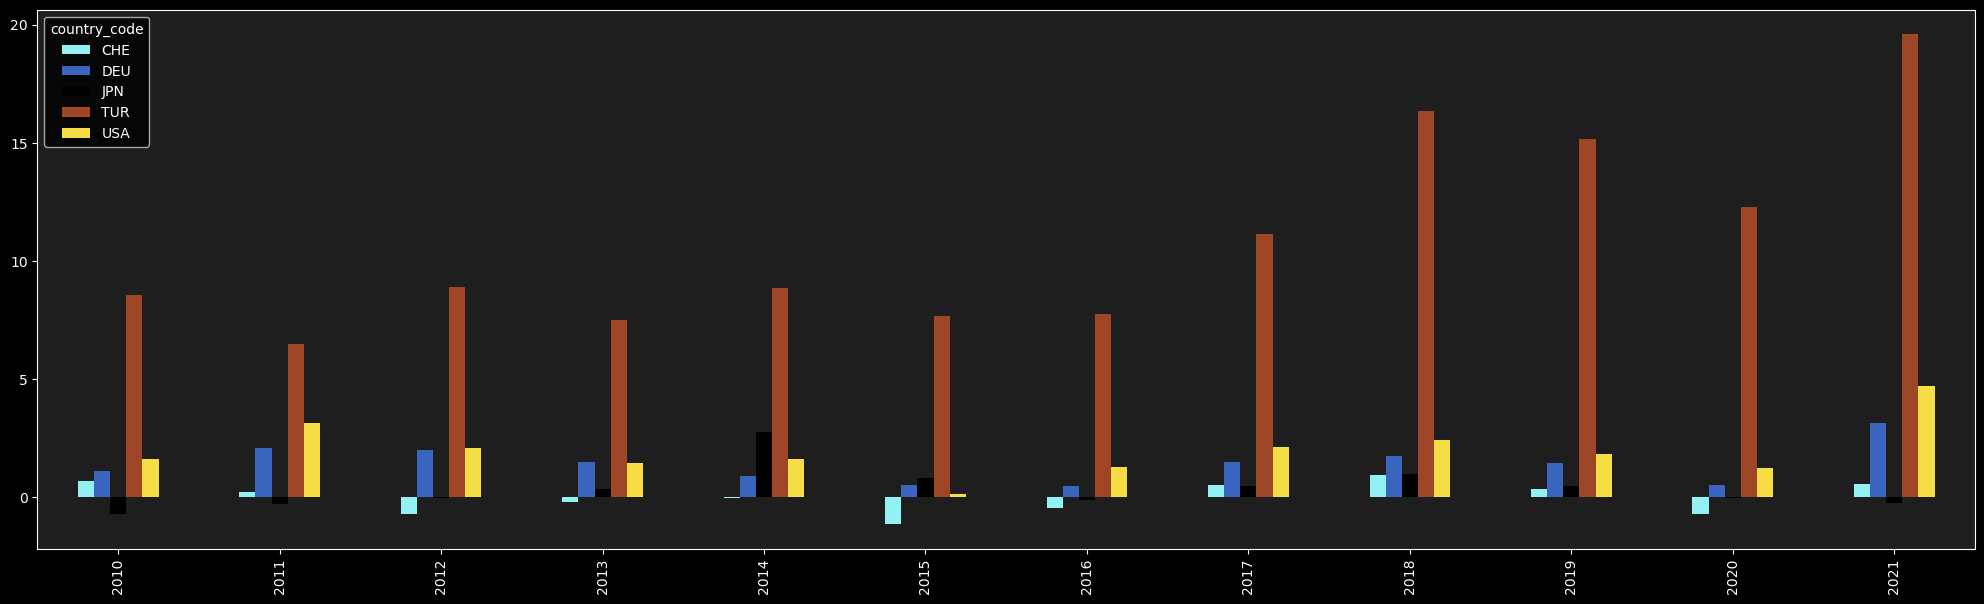

In [7]:
cmap = cmr.iceburn
p = inflation.tail(12).plot(figsize=(25,7), kind="bar", cmap=cmap)
p.set_facecolor("#1e1e1e")

In [8]:
def decade(decade: int) -> str:
    years = range(decade, decade+10)
    addition = " + ".join([f"year_{year}" for year in years])
    case = lambda year : f"case when year_{year} is not null then 1 else 0 end"
    cases = (" + ".join([case(year) for year in years]))
    name = f"avg_{decade}"
    return f"(({addition}) / nullif (({cases}), 0)) as {name}"

def decades(years: list[int]) -> str:
    return ", ".join([decade(year) for year in years])

query = " ".join([
    "SELECT * FROM ("
    "SELECT",
    ", ".join([
        "country_name",
        "country_code", 
        decades(range(1970,2020, 10)), 
    ]),
    "FROM inflation",
    ") AS data WHERE avg_2010 BETWEEN 0 AND 1"
    ],
)
with db_connection() as conn:
    averages_raw = pd.read_sql_query(query, conn)
averages_raw


,country_name,country_code,avg_1970,avg_1980,avg_1990,avg_2000,avg_2010
0,Burkina Faso,BFA,8.083891,5.020517,4.528556,3.029875,0.746077
1,Bosnia and Herzegovina,BIH,NaN,NaN,NaN,NaN,0.689980
2,Switzerland,CHE,4.975580,3.270293,2.340140,0.954082,0.025099
3,Cyprus,CYP,6.808237,5.797596,3.865810,2.757392,0.504566
4,Dominica,DMA,NaN,NaN,2.341360,2.006107,0.832826
5,Greece,GRC,12.309725,19.472078,11.111969,3.158290,0.674918
6,Ireland,IRL,12.750610,9.337939,2.322840,3.160913,0.550893
7,Japan,JPN,9.017245,2.529801,1.210592,-0.255155,0.465959
8,St. Kitts and Nevis,KNA,NaN,4.812504,3.518826,3.474781,0.519630
9,Mali,MLI,NaN,NaN,4.179620,2.608382,0.971696


In [9]:
averages = averages_raw.transpose()
averages.columns = averages_raw["country_name"]
averages.index = averages_raw.columns
items = [n for n in averages_raw.columns if n.startswith("avg")]
averages = averages.filter(items=items, axis=0)
averages = averages.rename(mapper=lambda n : n.replace("avg_", ""))
averages

country_name,Burkina Faso,Bosnia and Herzegovina,Switzerland,Cyprus,Dominica,Greece,Ireland,Japan,St. Kitts and Nevis,Mali,Niger
1970,8.083891,NaN,4.97558,6.808237,NaN,12.309725,12.75061,9.017245,NaN,NaN,10.350079
1980,5.020517,NaN,3.270293,5.797596,NaN,19.472078,9.337939,2.529801,4.812504,NaN,3.565477
1990,4.528556,NaN,2.34014,3.86581,2.34136,11.111969,2.32284,1.210592,3.518826,4.17962,4.28096
2000,3.029875,NaN,0.954082,2.757392,2.006107,3.15829,3.160913,-0.255155,3.474781,2.608382,2.796263
2010,0.746077,0.68998,0.025099,0.504566,0.832826,0.674918,0.550893,0.465959,0.51963,0.971696,0.992048


<AxesSubplot: >

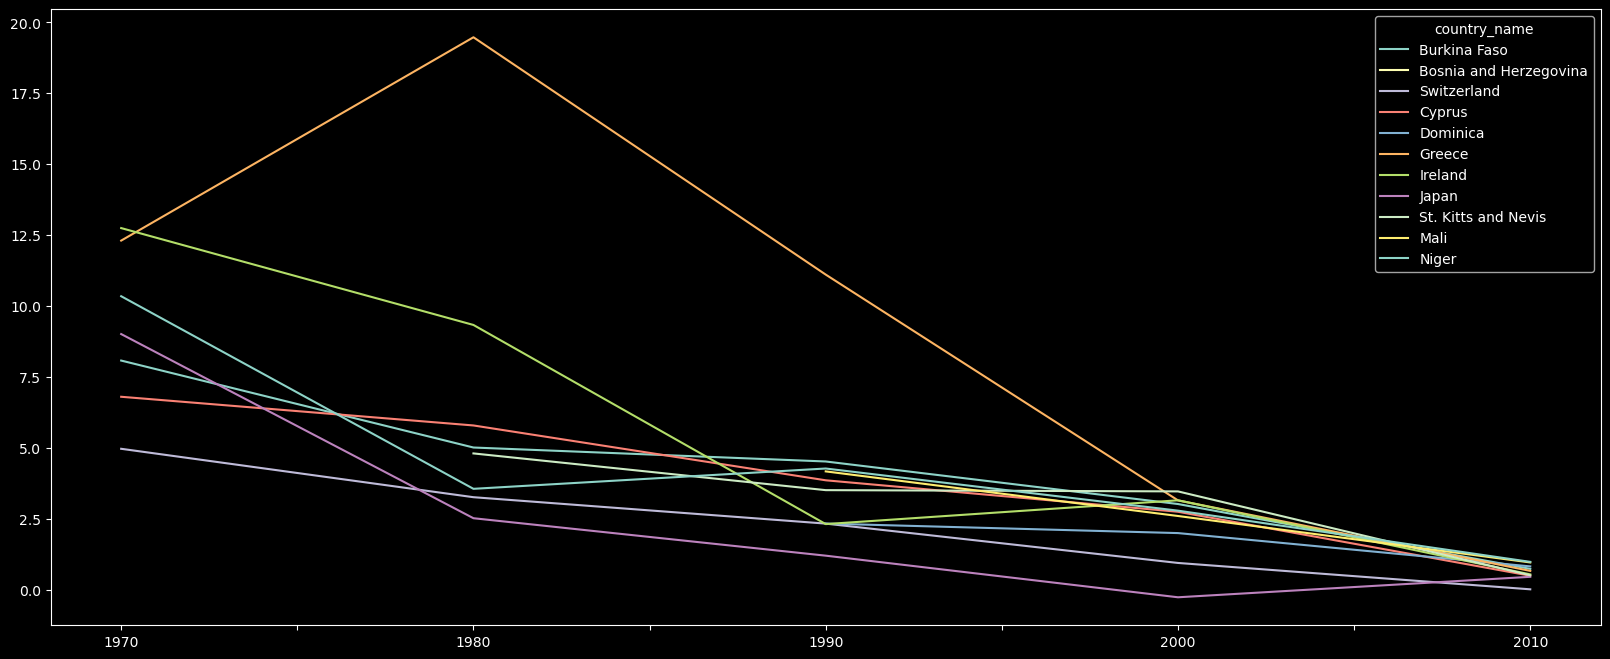

In [10]:
averages.plot(figsize=(20, 8))